# 0. Reading the Data
I will start with ride ID = 2975587283 which is the first ride of 2020 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [2]:
file_paths = {'in':'../../data/processed/activities/2975587283.csv'
             }

In [8]:
df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
df['time'] = pd.to_datetime(df['time'])

In [9]:
df.head()

,track,segment_id,time,elevation,latitude,longitude
0,2975587283,0,2020-01-02 14:02:58+00:00,224.3,40.042824,-83.027358
1,2975587283,0,2020-01-02 14:03:00+00:00,224.2,40.042877,-83.027490
2,2975587283,0,2020-01-02 14:03:02+00:00,224.2,40.042914,-83.027581
3,2975587283,0,2020-01-02 14:03:04+00:00,224.2,40.042934,-83.027644
4,2975587283,0,2020-01-02 14:06:04+00:00,224.2,40.042900,-83.027659


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   track       872 non-null    int64              
 1   segment_id  872 non-null    int64              
 2   time        872 non-null    datetime64[ns, UTC]
 3   elevation   872 non-null    float64            
 4   latitude    872 non-null    float64            
 5   longitude   872 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(2)
memory usage: 41.0 KB


# 1. Creating Delta Time

In [11]:
# Temporarily get the number of seconds since Jan. 1, 1970 as the UTC timestamp
df['time_utc'] = df['time'].apply(lambda x: x.timestamp())

In [12]:
# Calculate the row-wise difference in time (in seconds)
df['delta_time'] = df['time_utc'].diff()

In [13]:
df.head()

,track,segment_id,time,elevation,latitude,longitude,time_utc,delta_time
0,2975587283,0,2020-01-02 14:02:58+00:00,224.3,40.042824,-83.027358,1.577974e+09,NaN
1,2975587283,0,2020-01-02 14:03:00+00:00,224.2,40.042877,-83.027490,1.577974e+09,2.0
2,2975587283,0,2020-01-02 14:03:02+00:00,224.2,40.042914,-83.027581,1.577974e+09,2.0
3,2975587283,0,2020-01-02 14:03:04+00:00,224.2,40.042934,-83.027644,1.577974e+09,2.0
4,2975587283,0,2020-01-02 14:06:04+00:00,224.2,40.042900,-83.027659,1.577974e+09,180.0


In [14]:
df['delta_time'].value_counts()

2.0      455
1.0      403
3.0        8
180.0      1
23.0       1
15.0       1
10.0       1
29.0       1
Name: delta_time, dtype: int64

# 2. Creating the Elapsed Time Column

In [15]:
# create an elapsed time column
df['elapsed_time'] = df['delta_time'].cumsum()

# 3. Visualize the Row-wise Time Discontinuities

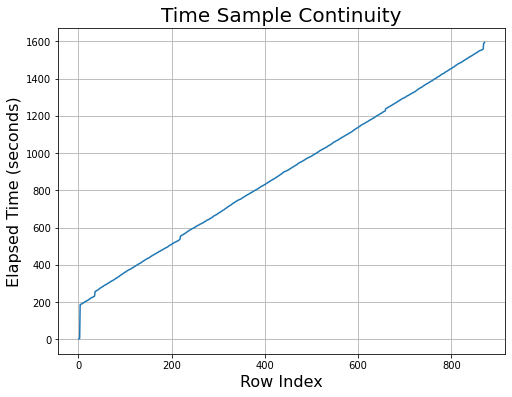

In [16]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,6))

_ = plt.plot(df['elapsed_time'])
_ = plt.xlabel('Row Index', fontsize=16)
_ = plt.ylabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.title('Time Sample Continuity', fontsize=20)
_ = plt.grid()

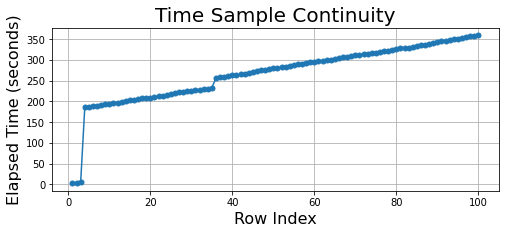

In [19]:
# visualize the jumps of cumulative time 
fig = plt.figure(figsize=(8,3))

_ = plt.plot(df.loc[0:100, 'elapsed_time'], linestyle='-', marker='.', markersize=10)
_ = plt.xlabel('Row Index', fontsize=16)
_ = plt.ylabel('Elapsed Time (seconds)', fontsize=16)
_ = plt.title('Time Sample Continuity', fontsize=20)
_ = plt.grid()

### Are there major discontinuities in Localization States?

In [55]:
# Calculate when the time discontinuities occur
time_gap_threshold = 15 # seconds
filt_time_jump = df['delta_time'] >= time_gap_threshold
discontinuty_indices = list(df.loc[filt_time_jump, 'time'].index)

In [56]:
def plot_state_by_index(df, state_column, discontinuities, figsize=(8,3), row_bounds=None, y_lim_scale=0.005):
    fig = plt.figure(figsize=figsize)
    # Mark the discontinuities
    for discont_index in discontinuty_indices:
        _ = plt.axvline(discont_index, color='r')
    
    # Plot the state
    _ = plt.plot(df.loc[:, state_column], linestyle='-', marker='.', markersize=10)
    _ = plt.xlabel('Row Index', fontsize=16)
    _ = plt.ylabel(f'{state_column}', fontsize=16)
    _ = plt.title(f'Time Sample Continuity of {state_column}', fontsize=20)
    _ = plt.grid()
    
    # Manage the axes limits
    if row_bounds is not None:
        _ = plt.xlim(row_bounds)
    else:
        row_bounds = [0, df.shape[0]-1]
        
    y_min = np.min(df.loc[row_bounds, state_column])
    y_max = np.max(df.loc[row_bounds, state_column])
    
    _ = plt.ylim([(1-y_lim_scale)*y_min, (1+y_lim_scale)*y_max])
    #_ = plt.ylim([y_min, y_max])
    

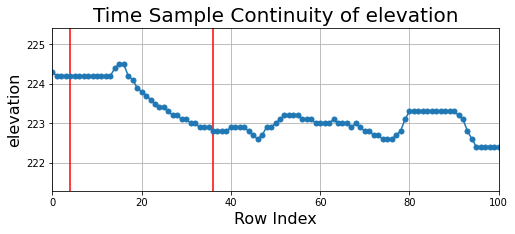

In [57]:
plot_state_by_index(df, 'elevation', discontinuty_indices, row_bounds=[0, 100])

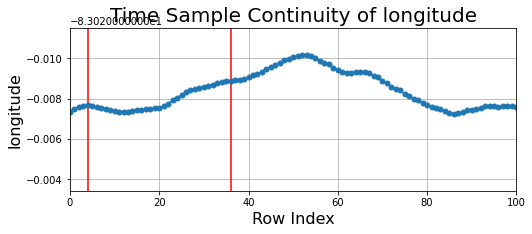

In [58]:
plot_state_by_index(df, 'longitude', discontinuty_indices, row_bounds=[0, 100], y_lim_scale=0.00005)

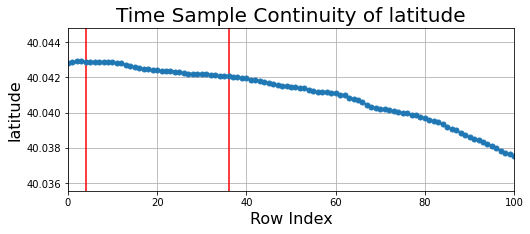

In [59]:
plot_state_by_index(df, 'latitude', discontinuty_indices, row_bounds=[0, 100], y_lim_scale=0.00005)

# 4. Segment ID Creation
For every segment of the ride where `delta_time` < `time_gap_threshold`, we need to assign an 

In [60]:
df.head()

,track,segment_id,time,elevation,latitude,longitude,time_utc,delta_time,elapsed_time
0,2975587283,0,2020-01-02 14:02:58+00:00,224.3,40.042824,-83.027358,1.577974e+09,NaN,NaN
1,2975587283,0,2020-01-02 14:03:00+00:00,224.2,40.042877,-83.027490,1.577974e+09,2.0,2.0
2,2975587283,0,2020-01-02 14:03:02+00:00,224.2,40.042914,-83.027581,1.577974e+09,2.0,4.0
3,2975587283,0,2020-01-02 14:03:04+00:00,224.2,40.042934,-83.027644,1.577974e+09,2.0,6.0
4,2975587283,0,2020-01-02 14:06:04+00:00,224.2,40.042900,-83.027659,1.577974e+09,180.0,186.0
